# Filtrando e reduzindo/cortando mensagens

## Visão geral

Agora, vamos nos aprofundar em  alguns conceitos:

* Como personalizar o schema de estado do grafo
* Como definir reducers de estado personalizados
* Como usar múltiplos schemas de estado do grafo

## Objetivos

Agora, podemos começar a usar esses conceitos com modelos no LangGraph!

Nas próximas sessões, vamos construir um chatbot que tem memória de longo prazo.

Como nosso chatbot usará mensagens, vamos primeiro falar um pouco mais sobre formas avançadas de trabalhar com mensagens no estado do grafo.

In [53]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [54]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Usaremos o [LangSmith](https://docs.smith.langchain.com/) para [rastreamento](https://docs.smith.langchain.com/concepts/tracing).

Faremos o registro em um projeto, `scoras-academy`.

In [55]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "scoras-academy"

## Mensagens como estado

Primeiro, vamos definir algumas mensagens.

In [70]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"Então você disse que estava pesquisando sobre agentes de IA?", name="Bot")]
messages.append(HumanMessage(f"Sim, eu conheço sobre agentes conversacionais. Mas quais outros eu deveria aprender?", name="Anderson"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Então você disse que estava pesquisando sobre agentes de IA?
================================ Human Message =================================
Name: Anderson

Sim, eu conheço sobre agentes conversacionais. Mas quais outros eu deveria aprender?


Lembre-se que podemos passá-las para um modelo de chat.


In [71]:
# Importando o modelo de chat da OpenAI
from langchain_openai import ChatOpenAI

# Inicializando o modelo GPT-4 Mini
llm = ChatOpenAI(model="gpt-4o-mini")

# Invocando o modelo com as mensagens definidas anteriormente
llm.invoke(messages)

AIMessage(content='Além de agentes conversacionais, existem vários outros tipos de agentes de inteligência artificial que você pode considerar explorar:\n\n1. **Agentes Autônomos**: Esses agentes operam de forma independente em ambientes dinâmicos, como robôs que podem navegar e tomar decisões sem intervenção humana.\n\n2. **Agentes de Aprendizado de Máquina**: Esses agentes utilizam algoritmos de aprendizado de máquina para melhorar seu desempenho com base em dados. Eles podem ser usados em recomendações de produtos, reconhecimento de padrões, etc.\n\n3. **Agentes de Planejamento**: Esses agentes são projetados para criar planos de ação para atingir objetivos específicos, levando em consideração restrições e recursos disponíveis.\n\n4. **Agentes de Negociação**: Esses agentes podem interagir uns com os outros para chegar a acordos, sendo úteis em vendas, logística e outras áreas onde a negociação é necessária.\n\n5. **Agentes de Recomendação**: Usados em plataformas como Netflix e Ama

Podemos executar nosso modelo de chat em um grafo simples com `MessagesState`.


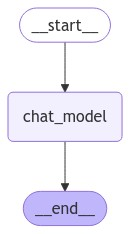

In [72]:
# Importando bibliotecas necessárias
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Definindo o nó que processará as mensagens usando o modelo de chat
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Construindo o grafo
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)  # Adicionando o nó do modelo de chat
builder.add_edge(START, "chat_model")  # Conectando o início ao nó do chat
builder.add_edge("chat_model", END)  # Conectando o nó do chat ao fim
graph = builder.compile()  # Compilando o grafo

# Visualizando o grafo usando Mermaid
display(Image(graph.get_graph().draw_mermaid_png()))

In [73]:
# Invocando o grafo com as mensagens e armazenando a saída
output = graph.invoke({'messages': messages})

# Imprimindo cada mensagem do resultado de forma formatada
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Então você disse que estava pesquisando sobre agentes de IA?
================================ Human Message =================================
Name: Anderson

Sim, eu conheço sobre agentes conversacionais. Mas quais outros eu deveria aprender?
================================== Ai Message ==================================

Além dos agentes conversacionais, existem vários outros tipos de agentes de IA que você pode explorar:

1. **Agentes de Recomendação**: Utilizados em plataformas como Netflix e Amazon, eles analisam o comportamento do usuário para sugerir filmes, músicas ou produtos.

2. **Agentes de Aprendizado de Máquina**: Esses agentes usam algoritmos de aprendizado de máquina para melhorar seu desempenho em tarefas específicas com base em dados.

3. **Agentes Autônomos**: Robôs ou veículos autônomos que tomam decisões em tempo real, como drones ou carros autônomos.

4. **Agentes de Jogo**

## Reducer

Um desafio prático ao trabalhar com mensagens é gerenciar conversas longas.

Conversas longas resultam em alto uso de tokens e latência se não formos cuidadosos, porque passamos uma lista crescente de mensagens para o modelo.

Temos algumas maneiras de lidar com isso.

Primeiro, lembre-se do truque que vimos usando `RemoveMessage` e o reducer `add_messages`.

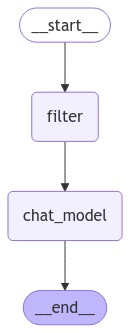

In [74]:
# Importando a classe RemoveMessage
from langchain_core.messages import RemoveMessage

# Definindo os nós
def filter_messages(state: MessagesState):
    # Excluir todas as mensagens exceto as 2 mais recentes
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Construindo o grafo
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)  # Adicionando o nó de filtro
builder.add_node("chat_model", chat_model_node)  # Adicionando o nó do modelo de chat
builder.add_edge(START, "filter")  # Conectando início ao filtro
builder.add_edge("filter", "chat_model")  # Conectando filtro ao chat
builder.add_edge("chat_model", END)  # Conectando chat ao fim
graph = builder.compile()  # Compilando o grafo

# Visualizando o grafo
display(Image(graph.get_graph().draw_mermaid_png()))

In [75]:
# Lista de mensagens com um preâmbulo
messages = [AIMessage("Olá.", name="Bot", id="1")]
messages.append(HumanMessage("Olá.", name="Anderson", id="2"))
messages.append(AIMessage("Então você disse que estava pesquisando sobre agentes de IA?", name="Bot", id="3"))
messages.append(HumanMessage("Sim, eu conheço sobre agentes conversacionais. Mas quais outros eu deveria aprender?", name="Anderson", id="4"))

# Invocando o grafo
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Então você disse que estava pesquisando sobre agentes de IA?
================================ Human Message =================================
Name: Anderson

Sim, eu conheço sobre agentes conversacionais. Mas quais outros eu deveria aprender?
================================== Ai Message ==================================

Além dos agentes conversacionais, existem vários outros tipos de agentes de IA que podem ser interessantes para você explorar:

1. **Agentes de Recomendação**: Esses agentes analisam o comportamento do usuário e fornecem recomendações personalizadas, como em plataformas de streaming (Netflix, Spotify) ou e-commerce (Amazon).

2. **Agentes de Aprendizado de Máquina**: Esses agentes utilizam algoritmos de aprendizado de máquina para melhorar seu desempenho ao longo do tempo com base em dados de entrada.

3. **Robôs Autônomos**: Esses agentes são projetados para operar em ambient

## Filtrando mensagens

Se você não precisa ou não quer modificar o estado do grafo, você pode simplesmente filtrar as mensagens que passa para o modelo de chat.

Por exemplo, basta passar uma lista filtrada: `llm.invoke(messages[-1:])` para o modelo.

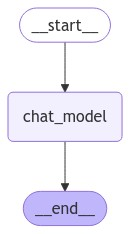

In [76]:
# Definindo o nó
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Construindo o grafo
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)  # Adicionando o nó do chat
builder.add_edge(START, "chat_model")  # Conectando início ao chat
builder.add_edge("chat_model", END)  # Conectando chat ao fim
graph = builder.compile()  # Compilando o grafo

# Visualizando o grafo
display(Image(graph.get_graph().draw_mermaid_png()))

Vamos pegar nossa lista existente de mensagens, adicionar a resposta do LLM acima e adicionar uma pergunta de acompanhamento

In [77]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Me fale mais sobre Agentes de Planejamento!", name="Anderson"))

In [78]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Olá.
================================ Human Message =================================
Name: Anderson

Olá.
================================== Ai Message ==================================
Name: Bot

Então você disse que estava pesquisando sobre agentes de IA?
================================ Human Message =================================
Name: Anderson

Sim, eu conheço sobre agentes conversacionais. Mas quais outros eu deveria aprender?
================================== Ai Message ==================================

Além dos agentes conversacionais, existem vários outros tipos de agentes de IA que podem ser interessantes para você explorar:

1. **Agentes de Recomendação**: Esses agentes analisam o comportamento do usuário e fornecem recomendações personalizadas, como em plataformas de streaming (Netflix, Spotify) ou e-commerce (Amazon).

2. **Agentes de Aprendizado de Máquina**: Esses agentes 

In [79]:
# Invocando o grafo, usando filtragem de mensagens
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Olá.
================================ Human Message =================================
Name: Anderson

Olá.
================================== Ai Message ==================================
Name: Bot

Então você disse que estava pesquisando sobre agentes de IA?
================================ Human Message =================================
Name: Anderson

Sim, eu conheço sobre agentes conversacionais. Mas quais outros eu deveria aprender?
================================== Ai Message ==================================

Além dos agentes conversacionais, existem vários outros tipos de agentes de IA que podem ser interessantes para você explorar:

1. **Agentes de Recomendação**: Esses agentes analisam o comportamento do usuário e fornecem recomendações personalizadas, como em plataformas de streaming (Netflix, Spotify) ou e-commerce (Amazon).

2. **Agentes de Aprendizado de Máquina**: Esses agentes 

O estado tem todas as mensagens.

Mas, vamos olhar o rastreamento do LangSmith para ver que a invocação do modelo usa apenas a última mensagem:

https://smith.langchain.com/o/1226c5ea-8147-4279-93da-5cecd121c83c/projects/p/25ad813a-7ede-456d-813f-ccc2b8b7261d?timeModel=%7B%22duration%22%3A%227d%22%7D

## Reduzir (Trim/ cortar) mensagens

Outra abordagem é [reduzir mensagens](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), com base em um número definido de tokens.

Isso restringe o histórico de mensagens a um número específico de tokens.

Enquanto a filtragem apenas retorna um subconjunto pós-processado das mensagens entre agentes, a redução restringe o número de tokens que um modelo de chat pode usar para responder.

Veja o `trim_messages` abaixo.

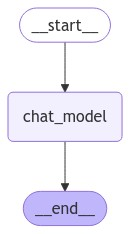

In [80]:
from langchain_core.messages import trim_messages

# Definindo o nó
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o-mini"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Construindo o grafo
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)  # Adicionando o nó do chat
builder.add_edge(START, "chat_model")  # Conectando início ao chat
builder.add_edge("chat_model", END)  # Conectando chat ao fim
graph = builder.compile()  # Compilando o grafo

# Visualizando o grafo
display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Me fale sobre os diferentes tipos de Agentes de IA!", name="Anderson"))

In [82]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Me fale sobre os diferentes tipos de Agentes de IA!', additional_kwargs={}, response_metadata={}, name='Anderson')]

In [83]:
# Invocando o grafo, usando redução de mensagens
messages_out_trim = graph.invoke({'messages': messages})

Vamos olhar o rastreamento do LangSmith para ver a invocação do modelo:

https://smith.langchain.com/o/1226c5ea-8147-4279-93da-5cecd121c83c/projects/p/25ad813a-7ede-456d-813f-ccc2b8b7261d?timeModel=%7B%22duration%22%3A%227d%22%7D

# Conceitos do LangGraph: Gerenciamento de Mensagens e Estados

## Visão Geral
Este notebook apresenta conceitos fundamentais sobre como gerenciar mensagens e estados em grafos do LangGraph, com foco especial em técnicas para otimizar conversas longas.

## Conceitos Principais

### 1. Estado de Mensagens
* O LangGraph utiliza `MessagesState` para gerenciar o histórico de conversas
* As mensagens podem ser do tipo `AIMessage` (respostas do modelo) ou `HumanMessage` (entradas do usuário)
* O estado mantém todas as mensagens da conversa em ordem cronológica

### 2. Grafo de Estados
* Construído usando `StateGraph`
* Possui nós (`nodes`) que processam as mensagens
* Utiliza arestas (`edges`) para conectar os nós
* Tem pontos definidos de `START` e `END`

### 3. Técnicas de Gerenciamento de Mensagens

#### a) Filtragem de Mensagens
* Permite selecionar apenas um subconjunto das mensagens
* Útil quando não é necessário modificar o estado do grafo
* Exemplo: `messages[-1:]` para usar apenas a última mensagem
* Reduz o uso de tokens e melhora a performance

#### b) Redução de Mensagens (Trimming)
* Limita o número de tokens no histórico de mensagens
* Usa a função `trim_messages`
* Parâmetros importantes:
  - `max_tokens`: limite máximo de tokens
  - `strategy`: estratégia de seleção ("last", etc.)
  - `token_counter`: modelo usado para contar tokens
  - `allow_partial`: permite ou não mensagens parciais

#### c) Reducer com RemoveMessage
* Permite remover mensagens específicas do estado
* Útil para manter apenas as mensagens mais relevantes
* Ajuda a controlar o tamanho do histórico de conversação

## Benefícios das Técnicas de Gerenciamento

1. **Otimização de Recursos**
   * Redução no uso de tokens
   * Menor latência nas respostas
   * Melhor gerenciamento de memória

2. **Controle de Contexto**
   * Mantém apenas as mensagens relevantes
   * Permite focar em partes específicas da conversa
   * Melhora a qualidade das respostas do modelo

3. **Flexibilidade**
   * Diferentes estratégias para diferentes necessidades
   * Possibilidade de combinar técnicas
   * Adaptável a diversos casos de uso

## Ferramentas de Monitoramento
* Uso do LangSmith para rastreamento
* Visualização do grafo com Mermaid
* Monitoramento de uso de tokens e performance

## Aplicações Práticas
* Chatbots com memória de longo prazo
* Sistemas de conversação otimizados
* Processamento eficiente de diálogos extensos

Esta estrutura do LangGraph fornece uma base sólida para construir aplicações de conversação complexas e eficientes, com controle granular sobre o gerenciamento de mensagens e estados.